In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from tqdm.auto import tqdm

from common.consts import RESULTS_DIR, EVAL_SIZE
from common.utils import filename_to_obj, remove_index

/home/tdolega/miniconda/envs/p311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def results_as_pandas(filename):
    path = os.path.join(RESULTS_DIR, filename)
    data = pd.read_json(path, lines=True)

    if len(data) == 0:
        print(f"empty file: {filename}")
        return data

    params = filename_to_obj(filename)
    for k, v in params.items():
        data[k] = v

    data = data.explode("evaluations")
    data = data.rename_axis("question_idx").reset_index()

    data = pd.concat([data, data["evaluations"].apply(pd.Series)], axis=1)
    evaluation_keys = data["evaluations"].apply(pd.Series).columns
    for col in evaluation_keys:
        data = pd.concat([data, data[col].apply(pd.Series).add_prefix(f"{col}/")], axis=1)
        data = data.drop(columns=col)
    data = data.drop(columns=["evaluations"])

    return data


files = os.listdir(RESULTS_DIR)
params_names = list(filename_to_obj(files[0]).keys())
all_results = pd.concat([results_as_pandas(f) for f in tqdm(files)])
all_results.head()

100%|██████████| 36/36 [01:29<00:00,  2.49s/it]


,question_idx,question_id,llm,prompt_id,temperature,nli,ellm,sim,citations/ais_recall,citations/ais_precision,...,citations/supported,citations/citations,citations/correct_citations,citations/out_of_range,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance,quality/new_question
0,0,5abab42e55429955dce3eed2,Mistral-7B-Instruct-v0.2,1,1.0,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,0.142857,0.333333,...,"[0, 0, 1, 0, 0, 0, 0]","[[], [], [5], [], [], [], [4, 7]]","[[], [], [1], [], [], [], [0]]","[0, 0, 0, 0, 0, 0, 0]",1.0,0.0,0.5,0.333333,0.542151,In what professional sports leagues do Moala T...
1,0,5abab42e55429955dce3eed2,Mistral-7B-Instruct-v0.2,1,1.0,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,0.250000,0.500000,...,"[0, 0, 0, 1]","[[], [], [4], [6]]","[[], [], [0], [1]]","[0, 0, 0, 0]",0.5,0.0,0.5,0.500000,0.561224,"Who are Jordan Subban and Auston Matthews, and..."
2,0,5abab42e55429955dce3eed2,Mistral-7B-Instruct-v0.2,1,1.0,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,0.200000,0.500000,...,"[0, 0, 0, 0, 1]","[[], [], [4], [], [3]]","[[], [], [0], [], [1]]","[0, 0, 0, 0, 0]",0.5,0.0,1.0,1.000000,0.640139,"Who are the hockey-playing brothers, one of wh..."
3,1,5a761900554299109176e648,Mistral-7B-Instruct-v0.2,1,1.0,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1.000000,1.000000,...,[1],"[[0, 1]]","[[True, True]]",[0],1.0,1.0,1.0,1.000000,0.401913,What company is associated with the Flynn inve...
4,1,5a761900554299109176e648,Mistral-7B-Instruct-v0.2,1,1.0,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1.000000,1.000000,...,[1],[[1]],[[1]],[0],1.0,1.0,0.5,1.000000,0.420150,What company is associated with the Flynn Inte...


In [3]:
all_obj_cols = all_results.select_dtypes(include=["object"]).columns
drop_obj_cols = list(set(all_obj_cols) - set(params_names))
drop_obj_cols.remove("question_id")
print(f"Dropping columns: {drop_obj_cols}")
all_num_results = all_results.drop(columns=drop_obj_cols)

Dropping columns: ['citations/correct_citations', 'citations/out_of_range', 'citations/sentences', 'citations/citations', 'quality/new_question', 'citations/supported']


In [4]:
eval_split = all_num_results[all_num_results["question_idx"] < EVAL_SIZE]
train_split = all_num_results[all_num_results["question_idx"] >= EVAL_SIZE]

In [5]:
SAMPLES_AGG_FUNC = "mean"  # or "max"


def merge_mean_std(df):
    ndf = pd.DataFrame()
    for main_column, sub_column in df.columns[::2]:
        if sub_column == "":
            ndf[main_column] = df[main_column]
        else:
            main = df[main_column][SAMPLES_AGG_FUNC]
            std = df[main_column]["std"]
            if main_column in ["citations/ais_recall", "citations/ais_precision", "correctness/answer_overlap", "correctness/answer_entail", "correctness/citations_recall", "correctness/citations_precision", "quality/answer_relevance"]:
                main = (main * 100).round(1).astype(str) + "%"
                std = (std * 100).round(1).astype(str) + "%"
            else:
                main = main.round(1).astype(str)
                std = std.round(1).astype(str)
            # std = std.str.rjust(5, " ") # doesn't work for some reason
            ndf[main_column] = main + " ± " + std
    return ndf


def aggregate(split):
    split = split.drop(columns=["question_idx"])
    results_with_std_for_each_question = split.groupby([*params_names, "question_id"]).agg([SAMPLES_AGG_FUNC, "std"])
    results_for_each_model = results_with_std_for_each_question.groupby(params_names)
    results = results_for_each_model.mean()
    results["n_questions"] = results_for_each_model.size()
    results = merge_mean_std(results)
    return results


eval_results = aggregate(eval_split)
train_results = aggregate(train_split)

if eval_results["n_questions"].nunique() != 1:
    print("Warning: not all rows in evaluation have the same number of examples")

In [6]:
display(Markdown("### Prompts comparison"))
parameter_results = eval_results[eval_results.index.get_level_values("llm") == "Mistral-7B-Instruct-v0.2"]

RESULTS_COLUMNS = ["citations/ais_recall", "citations/ais_precision", "correctness/answer_overlap", "correctness/answer_entail", "correctness/citations_recall", "correctness/citations_precision", "quality/answer_relevance"]


def show_cleaned_results(short_eval_display, keep_index_name=None, keep_columns=RESULTS_COLUMNS):
    short_eval_display = short_eval_display.copy()
    for index_name in ["llm", "temperature", "nli", "ellm", "sim", "prompt_id"]:
        if keep_index_name == True or index_name == keep_index_name or index_name not in short_eval_display.index.names:
            continue
        short_eval_display = remove_index(short_eval_display, index_name)
    short_eval_display = short_eval_display[keep_columns]
    return short_eval_display


prompts_comparison = show_cleaned_results(parameter_results[parameter_results.index.get_level_values("temperature") == "0.1"], keep_index_name="prompt_id")
prompts_comparison

### Prompts comparison

,citations/ais_recall,citations/ais_precision,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance
prompt_id,,,,,,,
1,57.1% ± 4.1%,69.1% ± 6.2%,87.3% ± 1.5%,88.7% ± 1.7%,75.2% ± 2.6%,72.2% ± 5.0%,71.0% ± 3.9%
2,50.3% ± 6.7%,64.2% ± 6.4%,85.5% ± 2.8%,86.0% ± 2.3%,77.0% ± 4.3%,67.1% ± 4.7%,69.1% ± 3.7%
3,58.0% ± 4.5%,72.1% ± 5.7%,85.6% ± 1.7%,86.3% ± 1.2%,66.5% ± 3.5%,65.8% ± 4.2%,65.6% ± 2.7%
4,50.7% ± 5.1%,65.7% ± 6.9%,84.3% ± 2.4%,83.7% ± 1.2%,60.2% ± 3.2%,69.0% ± 3.6%,67.1% ± 3.0%


In [7]:
display(Markdown("### Temperature comparison"))
temperature_comparison = show_cleaned_results(parameter_results[parameter_results.index.get_level_values("prompt_id") == "1"], keep_index_name="temperature")
temperature_comparison

### Temperature comparison

,citations/ais_recall,citations/ais_precision,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance
temperature,,,,,,,
0.01,57.6% ± 2.7%,70.1% ± 3.6%,85.9% ± 1.3%,88.3% ± 1.7%,75.8% ± 1.4%,74.4% ± 2.3%,72.6% ± 2.3%
0.1,57.1% ± 4.1%,69.1% ± 6.2%,87.3% ± 1.5%,88.7% ± 1.7%,75.2% ± 2.6%,72.2% ± 5.0%,71.0% ± 3.9%
0.2,55.3% ± 8.3%,69.2% ± 10.4%,86.5% ± 3.0%,88.7% ± 0.6%,77.0% ± 5.2%,74.2% ± 5.1%,71.6% ± 4.8%
0.3,57.1% ± 8.3%,69.6% ± 11.3%,87.3% ± 4.6%,88.3% ± 2.3%,77.7% ± 6.0%,75.0% ± 6.7%,71.4% ± 5.2%
0.4,58.1% ± 15.1%,70.7% ± 19.4%,87.2% ± 4.5%,88.7% ± 2.9%,77.5% ± 9.7%,73.8% ± 10.0%,71.6% ± 6.7%
0.5,57.4% ± 14.5%,71.1% ± 16.9%,85.3% ± 7.4%,88.0% ± 3.5%,76.2% ± 8.2%,73.7% ± 11.4%,71.3% ± 6.2%
0.6,52.2% ± 16.7%,65.5% ± 21.6%,84.5% ± 4.9%,87.0% ± 4.0%,75.8% ± 12.2%,73.9% ± 12.6%,71.7% ± 7.2%
0.7,54.8% ± 19.1%,66.5% ± 24.1%,87.1% ± 4.7%,87.3% ± 2.9%,77.0% ± 11.9%,73.6% ± 13.2%,72.3% ± 6.9%
0.8,50.7% ± 19.6%,62.8% ± 23.6%,86.7% ± 6.3%,86.0% ± 8.7%,75.2% ± 12.0%,72.0% ± 12.4%,71.1% ± 7.4%


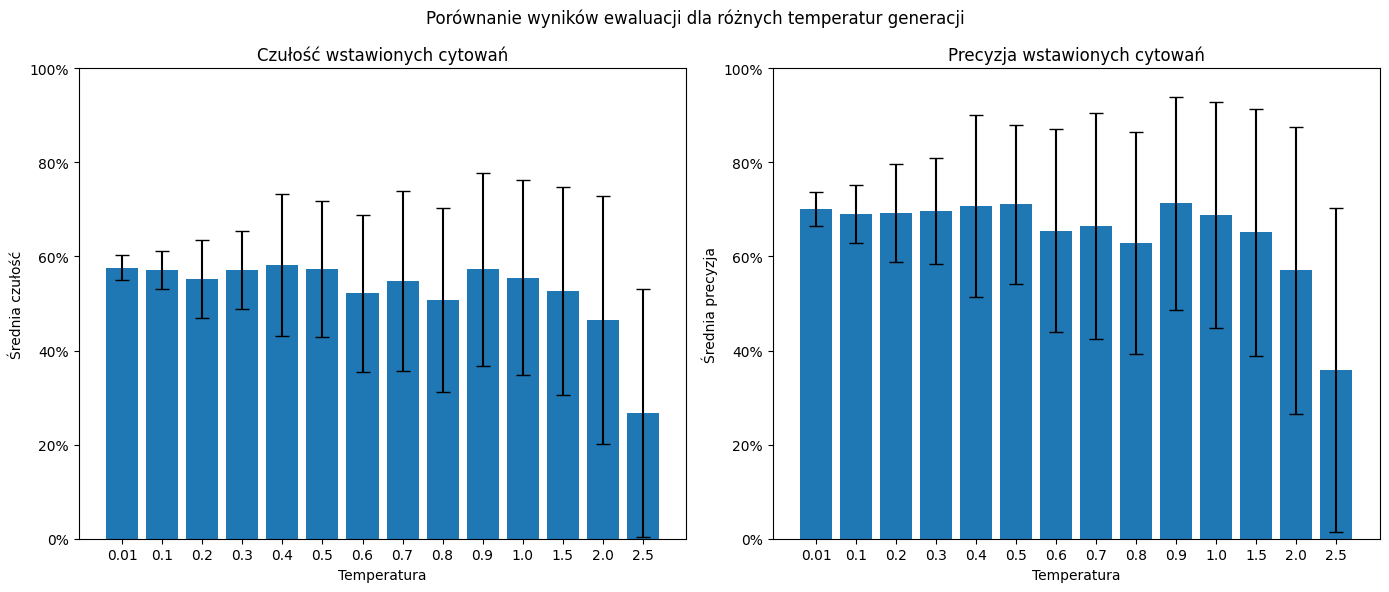

In [8]:
def separate_avg_std(x, as_num=False):
    parts = x.split(" ± ")
    if as_num:
        return float(parts[0][:-1]), float(parts[1][:-1])
    else:
        return parts


fig, axs = plt.subplots(1, 2, figsize=(14, 6))
for i, (column, column_nice) in enumerate([("citations/ais_recall", "Średnia czułość"), ("citations/ais_precision", "Średnia precyzja")]):
    val = temperature_comparison[column]
    avg, std = zip(*[separate_avg_std(x, as_num=True) for x in val])
    axs[i].bar(temperature_comparison.index.get_level_values("temperature"), avg, yerr=std, capsize=5)
    axs[i].set_ylim(0, 100)
    axs[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))
    axs[i].set_ylabel(column_nice)
    axs[i].set_xlabel("Temperatura")
    axs[i].set_title(column)
axs[0].set_title("Czułość wstawionych cytowań")
axs[1].set_title("Precyzja wstawionych cytowań")
fig.suptitle("Porównanie wyników ewaluacji dla różnych temperatur generacji")
plt.tight_layout()

In [9]:
display(Markdown("### Evaluation results"))
eval_not_mistral = eval_results[eval_results.index.get_level_values("llm") != "Mistral-7B-Instruct-v0.2"]
eval_mistral = eval_results[(eval_results.index.get_level_values("llm") == "Mistral-7B-Instruct-v0.2") & (eval_results.index.get_level_values("prompt_id") == "1") & (eval_results.index.get_level_values("temperature") == "0.1")]
eval_display = pd.concat([eval_not_mistral, eval_mistral])
eval_display = eval_display[eval_display.index.get_level_values("llm") != "Mixtral-8x7B-Instruct-v0.1.Q8_0"]  # use this model only for training data, because we already have same model without quantization
eval_display = remove_index(eval_display, "prompt_id")
eval_display = eval_display.sort_values(by=("correctness/citations_recall"), ascending=False)
# eval_display

### Evaluation results

In [10]:
cols = eval_display.columns
metadata_cols = cols[~cols.isin(RESULTS_COLUMNS)]
clean_metadata = show_cleaned_results(eval_display, keep_index_name=True, keep_columns=metadata_cols)
clean_metadata

,,,,,prompt_id,citations/n_sentences,citations/n_total_citations,citations/n_correct_citations,citations/n_correctly_multicited_sentences,citations/n_overcitations,n_questions
llm,temperature,nli,ellm,sim,,,,,,,
rag-tge_Llama-3-8B,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,4,1.5 ± 0.1,2.4 ± 0.2,2.0 ± 0.2,0.8 ± 0.1,0.2 ± 0.1,100
rag-tge_Mistral,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,4,1.4 ± 0.1,2.1 ± 0.1,1.8 ± 0.1,0.7 ± 0.1,0.2 ± 0.1,100
gpt-3.5-turbo-0125,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,2.0 ± 0.2,2.1 ± 0.2,2.0 ± 0.3,0.5 ± 0.1,0.0 ± 0.0,100
Mixtral-8x7B-Instruct-v0.1,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,2.1 ± 0.1,2.3 ± 0.2,1.7 ± 0.2,0.4 ± 0.1,0.3 ± 0.1,100
gpt-4-turbo,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,1.6 ± 0.2,1.8 ± 0.1,1.6 ± 0.1,0.5 ± 0.1,0.1 ± 0.0,100
Meta-Llama-3-70B-Instruct,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,1.5 ± 0.1,1.9 ± 0.1,1.5 ± 0.1,0.5 ± 0.1,0.2 ± 0.1,100
zephyr-orpo-141b-A35b-v0.1,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,2.0 ± 0.4,4.9 ± 1.3,3.2 ± 1.1,0.4 ± 0.1,1.6 ± 0.9,100
Meta-Llama-3-8B-Instruct,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,2.2 ± 0.2,2.0 ± 0.2,1.2 ± 0.2,0.3 ± 0.1,0.2 ± 0.1,100
Mistral-7B-Instruct-v0.2,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,2.6 ± 0.2,2.9 ± 0.3,2.1 ± 0.3,0.6 ± 0.1,0.6 ± 0.2,100


In [11]:
clean_results = show_cleaned_results(eval_display, keep_index_name="llm")
my_results = clean_results[clean_results.index.get_level_values("llm").str.contains("rag-tge")]
my_results

,citations/ais_recall,citations/ais_precision,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance
llm,,,,,,,
rag-tge_Llama-3-8B,83.6% ± 4.8%,85.7% ± 5.2%,89.4% ± 2.4%,92.0% ± 2.9%,96.7% ± 2.0%,97.9% ± 1.0%,74.1% ± 3.4%
rag-tge_Mistral,84.3% ± 5.8%,85.2% ± 5.6%,86.7% ± 1.7%,90.0% ± 1.2%,95.5% ± 1.4%,95.9% ± 1.5%,73.6% ± 4.0%


In [12]:
clean_results.style.apply(lambda x: ["font-weight: 1000" if "rag-tge" in x.name else "" for _ in x], axis=1)

for sort_by in [
    "citations/ais_recall",
    "citations/ais_precision",
    "correctness/answer_overlap",
    "correctness/answer_entail",
    "correctness/citations_recall",
    "correctness/citations_precision",
    "quality/answer_relevance",
]:
    display(Markdown(f"### sorted by: {sort_by}"))
    results = clean_results.sort_values(by=sort_by, ascending=False)
    results = results[[sort_by]]
    display(results)

### sorted by: citations/ais_recall

,citations/ais_recall
llm,
rag-tge_Mistral,84.3% ± 5.8%
rag-tge_Llama-3-8B,83.6% ± 4.8%
gpt-3.5-turbo-0125,73.8% ± 7.3%
gpt-4-turbo,73.0% ± 4.8%
Meta-Llama-3-70B-Instruct,69.5% ± 5.0%
Mixtral-8x7B-Instruct-v0.1,65.4% ± 6.1%
qwen1_5-14b-chat-q8_0,63.2% ± 4.5%
Mistral-7B-Instruct-v0.2,57.1% ± 4.1%
qwen1_5-110b-chat,52.9% ± 9.7%


### sorted by: citations/ais_precision

,citations/ais_precision
llm,
gpt-4-turbo,88.9% ± 3.6%
gpt-3.5-turbo-0125,88.8% ± 4.5%
rag-tge_Llama-3-8B,85.7% ± 5.2%
rag-tge_Mistral,85.2% ± 5.6%
qwen1_5-110b-chat,80.9% ± 10.9%
Meta-Llama-3-70B-Instruct,76.9% ± 5.1%
Mixtral-8x7B-Instruct-v0.1,74.6% ± 7.3%
qwen1_5-14b-chat-q8_0,69.5% ± 5.8%
Mistral-7B-Instruct-v0.2,69.1% ± 6.2%


### sorted by: correctness/answer_overlap

,correctness/answer_overlap
llm,
Meta-Llama-3-8B-Instruct,91.8% ± 0.0%
Mixtral-8x7B-Instruct-v0.1,91.0% ± 0.1%
rag-tge_Llama-3-8B,89.4% ± 2.4%
gpt-3.5-turbo-0125,88.4% ± 1.3%
gpt-4-turbo,87.7% ± 0.8%
qwen1_5-14b-chat-q8_0,87.6% ± 0.7%
qwen1_5-32b-chat-q8_0,87.4% ± 0.6%
Mistral-7B-Instruct-v0.2,87.3% ± 1.5%
qwen1_5-110b-chat,86.7% ± 2.0%


### sorted by: correctness/answer_entail

,correctness/answer_entail
llm,
rag-tge_Llama-3-8B,92.0% ± 2.9%
gpt-3.5-turbo-0125,91.0% ± 1.2%
Meta-Llama-3-8B-Instruct,90.3% ± 0.6%
gpt-4-turbo,90.0% ± 1.2%
rag-tge_Mistral,90.0% ± 1.2%
Mixtral-8x7B-Instruct-v0.1,89.7% ± 1.2%
qwen1_5-32b-chat-q8_0,89.7% ± 0.6%
qwen1_5-110b-chat,89.3% ± 1.7%
Mistral-7B-Instruct-v0.2,88.7% ± 1.7%


### sorted by: correctness/citations_recall

,correctness/citations_recall
llm,
rag-tge_Llama-3-8B,96.7% ± 2.0%
rag-tge_Mistral,95.5% ± 1.4%
gpt-3.5-turbo-0125,85.3% ± 2.3%
Mixtral-8x7B-Instruct-v0.1,82.5% ± 3.5%
gpt-4-turbo,79.5% ± 2.9%
Meta-Llama-3-70B-Instruct,78.5% ± 1.7%
zephyr-orpo-141b-A35b-v0.1,77.5% ± 9.2%
Meta-Llama-3-8B-Instruct,75.3% ± 2.3%
Mistral-7B-Instruct-v0.2,75.2% ± 2.6%


### sorted by: correctness/citations_precision

,correctness/citations_precision
llm,
rag-tge_Llama-3-8B,97.9% ± 1.0%
qwen1_5-32b-chat-q8_0,96.2% ± 0.0%
rag-tge_Mistral,95.9% ± 1.5%
gpt-3.5-turbo-0125,94.2% ± 2.4%
gpt-4-turbo,93.9% ± 1.1%
qwen1_5-110b-chat,93.0% ± 2.3%
qwen1_5-14b-chat-q8_0,92.0% ± 1.6%
Meta-Llama-3-8B-Instruct,90.8% ± 1.8%
Meta-Llama-3-70B-Instruct,90.8% ± 1.0%


### sorted by: quality/answer_relevance

,quality/answer_relevance
llm,
qwen1_5-7b-chat-q8_0,75.1% ± 5.1%
Meta-Llama-3-70B-Instruct,74.4% ± 2.4%
rag-tge_Llama-3-8B,74.1% ± 3.4%
gpt-3.5-turbo-0125,73.9% ± 5.4%
rag-tge_Mistral,73.6% ± 4.0%
qwen1_5-110b-chat,73.5% ± 4.8%
gemma-1.1-7b-it,73.4% ± 5.5%
gpt-4-turbo,72.8% ± 3.3%
qwen1_5-32b-chat-q8_0,72.2% ± 1.7%


In [13]:
display(Markdown("### Training results"))
train_display = remove_index(train_results, "prompt_id")
train_display

### Training results

,,,,,prompt_id,citations/ais_recall,citations/ais_precision,citations/n_sentences,citations/n_total_citations,citations/n_correct_citations,citations/n_correctly_multicited_sentences,citations/n_overcitations,correctness/answer_overlap,correctness/answer_entail,correctness/citations_recall,correctness/citations_precision,quality/answer_relevance,n_questions
llm,temperature,nli,ellm,sim,,,,,,,,,,,,,,
Meta-Llama-3-70B-Instruct,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,74.2% ± 3.1%,95.8% ± 1.1%,1.5 ± 0.1,2.0 ± 0.1,1.9 ± 0.1,0.6 ± 0.0,0.0 ± 0.0,88.7% ± 1.0%,89.2% ± 1.1%,81.0% ± 1.6%,91.1% ± 1.2%,74.3% ± 2.4%,17872
Mixtral-8x7B-Instruct-v0.1,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,67.0% ± 6.4%,93.2% ± 2.8%,2.1 ± 0.2,2.5 ± 0.3,2.3 ± 0.3,0.6 ± 0.1,0.0 ± 0.0,88.0% ± 1.7%,88.0% ± 2.0%,82.5% ± 3.8%,84.5% ± 3.8%,73.0% ± 3.5%,7659
Mixtral-8x7B-Instruct-v0.1.Q8_0,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,62.4% ± 7.0%,90.2% ± 3.5%,2.7 ± 0.3,3.0 ± 0.4,2.8 ± 0.3,0.7 ± 0.1,0.0 ± 0.0,87.5% ± 1.8%,87.8% ± 2.0%,84.8% ± 3.6%,79.7% ± 4.6%,72.5% ± 3.7%,6000
qwen1_5-110b-chat,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,56.5% ± 11.7%,94.6% ± 3.8%,1.9 ± 0.3,1.8 ± 0.2,1.7 ± 0.2,0.5 ± 0.1,0.0 ± 0.0,88.5% ± 2.2%,87.4% ± 2.5%,73.7% ± 5.4%,91.0% ± 3.7%,72.5% ± 4.4%,1000
qwen1_5-32b-chat-q8_0,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,55.0% ± 3.2%,96.7% ± 0.6%,1.6 ± 0.1,1.4 ± 0.0,1.3 ± 0.1,0.2 ± 0.0,0.0 ± 0.0,87.0% ± 1.0%,84.4% ± 0.0%,63.3% ± 2.2%,95.4% ± 0.3%,72.5% ± 1.9%,90
zephyr-orpo-141b-A35b-v0.1,0.1,t5_xxl_true_nli_mixture,Mistral-7B-Instruct-v0.2,all-MiniLM-L6-v2,1,44.3% ± 12.7%,79.0% ± 10.6%,2.0 ± 0.4,4.6 ± 1.3,3.2 ± 1.0,0.6 ± 0.2,0.1 ± 0.1,83.5% ± 3.6%,84.5% ± 3.5%,73.8% ± 9.7%,56.2% ± 10.6%,68.2% ± 6.4%,763


### Metrics corelation

In [14]:
corr_method = "pearson"  # "spearman", "kendall" or "pearson"
eval_split_copy = eval_split.copy()

citations_recall_corr = eval_split_copy[["citations/ais_recall", "correctness/citations_recall"]].corr(method=corr_method)
print("citations recall correlation:")
display(citations_recall_corr)

citations_precision_corr = eval_split_copy[["citations/ais_precision", "correctness/citations_precision"]].corr(method=corr_method)
print("citations precision correlation:")
display(citations_precision_corr)

answer_corr = eval_split_copy[["correctness/answer_overlap", "correctness/answer_entail"]].corr(method=corr_method)
print("answer correlation:")
display(answer_corr)


for col in ["citations/ais_recall", "citations/ais_precision", "correctness/answer_overlap", "correctness/answer_entail", "correctness/citations_recall", "correctness/citations_precision"]:
    eval_split_copy[col] = eval_split_copy[col] == eval_split_copy[col].max()
print("\n> binary columns created\n")


citations_recall_corr = eval_split_copy[["citations/ais_recall", "correctness/citations_recall"]].corr(method=corr_method)
print("citations recall correlation:")
display(citations_recall_corr)

citations_precision_corr = eval_split_copy[["citations/ais_precision", "correctness/citations_precision"]].corr(method=corr_method)
print("citations precision correlation:")
display(citations_precision_corr)

answer_corr = eval_split_copy[["correctness/answer_overlap", "correctness/answer_entail"]].corr(method=corr_method)
print("answer correlation:")
display(answer_corr)

citations recall correlation:


,citations/ais_recall,correctness/citations_recall
citations/ais_recall,1.00000,0.45609
correctness/citations_recall,0.45609,1.00000


citations precision correlation:


,citations/ais_precision,correctness/citations_precision
citations/ais_precision,1.000000,0.475579
correctness/citations_precision,0.475579,1.000000


answer correlation:


,correctness/answer_overlap,correctness/answer_entail
correctness/answer_overlap,1.000000,0.661116
correctness/answer_entail,0.661116,1.000000



> binary columns created

citations recall correlation:


,citations/ais_recall,correctness/citations_recall
citations/ais_recall,1.000000,0.161288
correctness/citations_recall,0.161288,1.000000


citations precision correlation:


,citations/ais_precision,correctness/citations_precision
citations/ais_precision,1.0000,0.3567
correctness/citations_precision,0.3567,1.0000


answer correlation:


,correctness/answer_overlap,correctness/answer_entail
correctness/answer_overlap,1.000000,0.653553
correctness/answer_entail,0.653553,1.000000
